# UCF 101 Action Recognition

INSTALLING LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!nvidia-smi


Sat Sep 23 07:49:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


In [2]:
cd /content/drive/MyDrive/Cognitica

/content/drive/MyDrive/Cognitica


In [ ]:
!pip install tensorflow

In [3]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model




In [ ]:
!pip install scikit-learn


     ---------------------------------------- 7.1/7.1 MB 6.7 MB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Note: you may need to restart the kernel to use updated packages.


# VISUALISATION

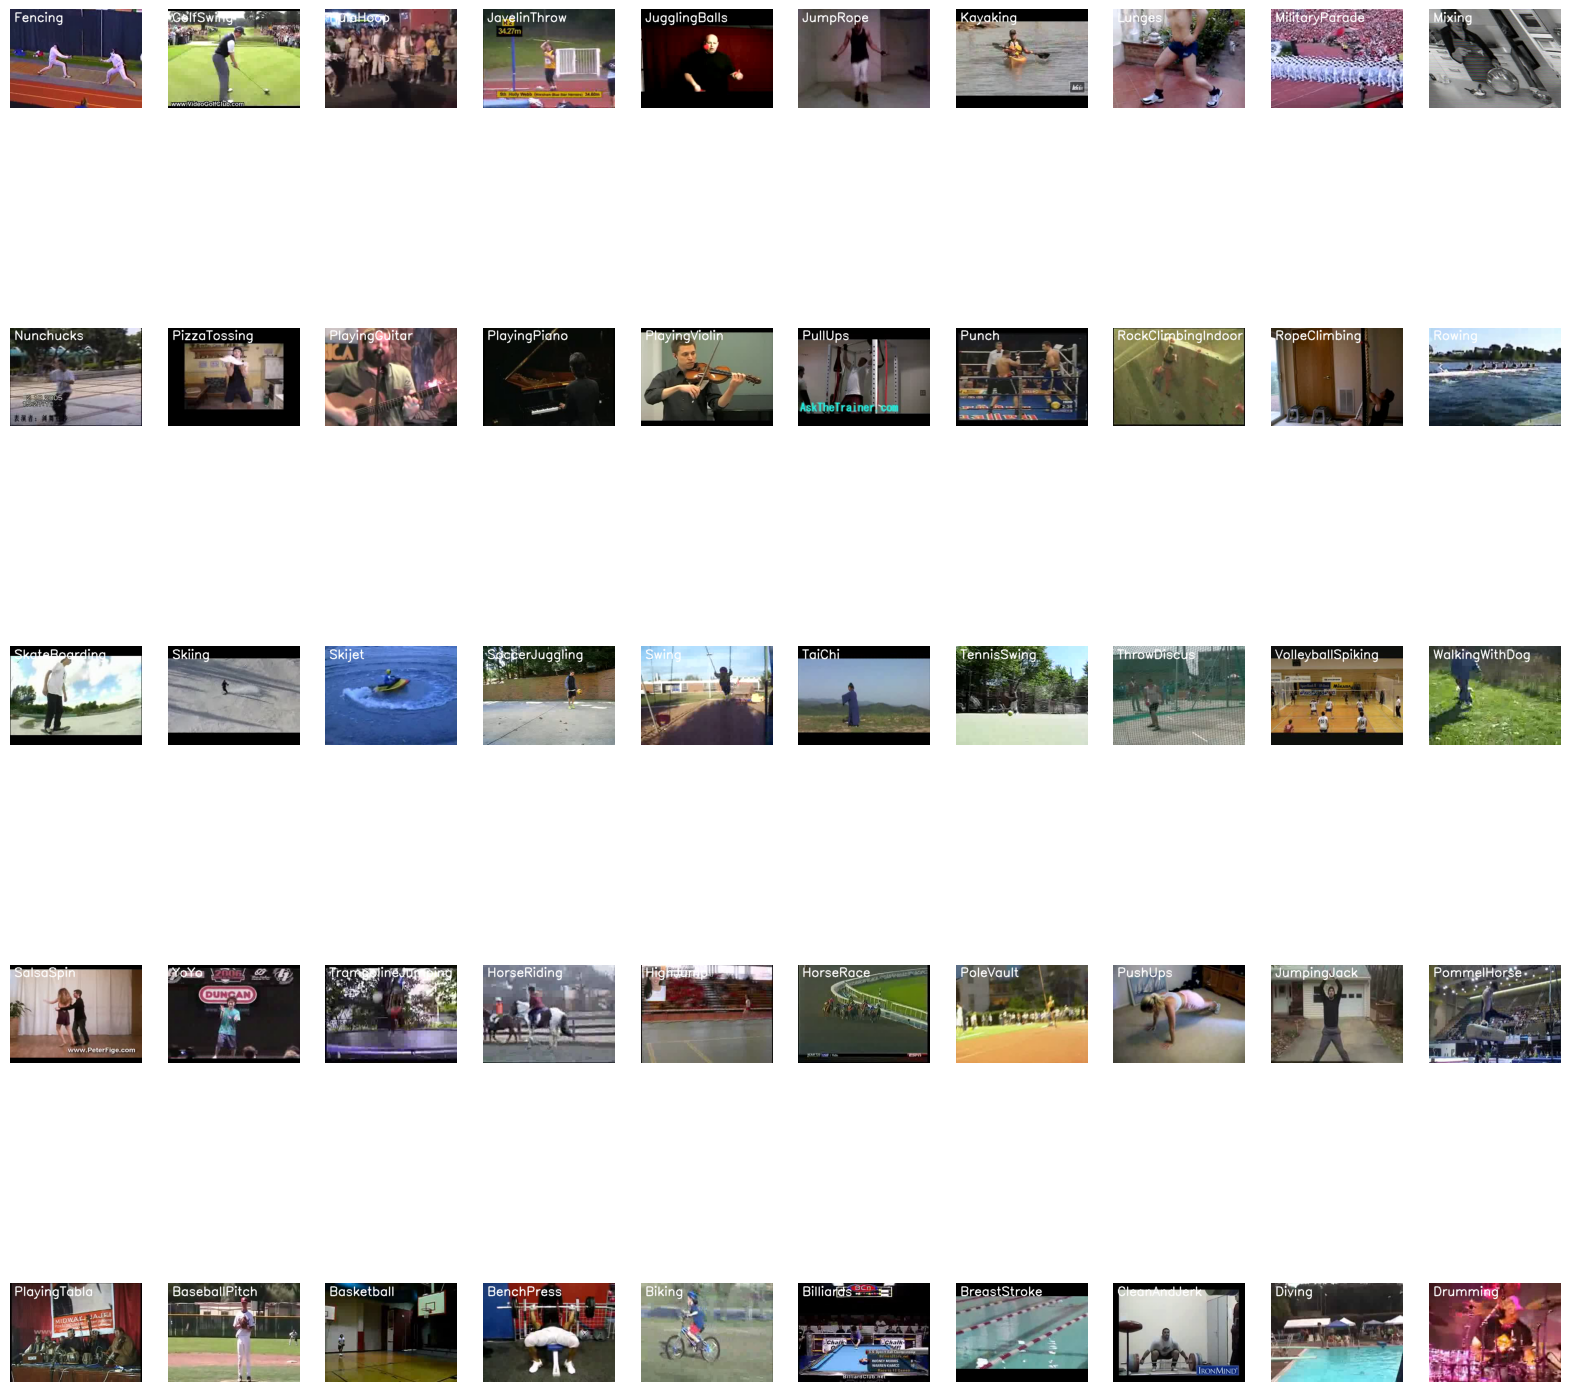

In [ ]:
import random

plt.figure(figsize=(20, 20))
all_classes_names = os.listdir('UCF50')

for counter, selected_class_Name in enumerate(all_classes_names, 1):
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Check if there are video files in the folder
    if video_files_names_list:
        selected_video_file_name = random.choice(video_files_names_list)
        video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
        _, bgr_frame = video_reader.read()
        video_reader.release()
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        plt.subplot(5, 10, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')
    else:
        print(f"No video files found in folder {selected_class_Name}")

plt.show()


In [4]:
IMAGE_HEIGHT,IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 20
DATASET_DIR="UCF50"
CLASSES_LIST=["PlayingTabla","PommelHorse","JumpingJack","PushUps","PoleVault","HorseRace","HighJump","Drumming","HorseRiding","Diving","BreastStroke",
              "Basketball","TrampolineJumping","YoYo","SalsaSpin","WalkingWithDog","VolleyballSpiking","ThrowDiscus","TennisSwing","TaiChi","Swing",
              "SoccerJuggling","Skijet","Skiing","SkateBoarding","Rowing","RopeClimbing","RockClimbingIndoor","Punch","PullUps","PlayingViolin","PlayingPiano","PlayingGuitar",
              "PizzaTossing","Nunchucks","Mixing","MilitaryParade","Lunges","Kayaking","JumpRope","JugglingBalls","JavelinThrow","HulaHoop","GolfSwing","Fencing",
              "CleanAndJerk","Billiards","Biking","BenchPress","BaseballPitch"]


# VIDEO PREPROCESSING

In [5]:
def frames_extraction(video_path):
  frames_list=[]
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame = video_reader.read()
    if not success:
      break

    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)
  video_reader.release()

  return frames_list



In [6]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []
  for class_index,class_name in enumerate(CLASSES_LIST[:40]):
    print(f'Extracting Data of CLass: {class_name}')

    files_list = os.listdir(os.path.join(DATASET_DIR,class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)

      frames = frames_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  features = np.asarray(features)
  labels = np.array(labels)

  return features,labels,video_files_paths



# FEATURE EXTRACTION

In [ ]:
features,labels,video_files_paths = create_dataset()


Extracting Data of CLass: PlayingTabla
Extracting Data of CLass: PommelHorse
Extracting Data of CLass: JumpingJack
Extracting Data of CLass: PushUps
Extracting Data of CLass: PoleVault
Extracting Data of CLass: HorseRace
Extracting Data of CLass: HighJump
Extracting Data of CLass: Drumming
Extracting Data of CLass: HorseRiding
Extracting Data of CLass: Diving
Extracting Data of CLass: BreastStroke
Extracting Data of CLass: Basketball
Extracting Data of CLass: TrampolineJumping
Extracting Data of CLass: YoYo
Extracting Data of CLass: SalsaSpin
Extracting Data of CLass: WalkingWithDog
Extracting Data of CLass: VolleyballSpiking
Extracting Data of CLass: ThrowDiscus
Extracting Data of CLass: TennisSwing
Extracting Data of CLass: TaiChi
Extracting Data of CLass: Swing
Extracting Data of CLass: SoccerJuggling
Extracting Data of CLass: Skijet
Extracting Data of CLass: Skiing
Extracting Data of CLass: SkateBoarding
Extracting Data of CLass: Rowing
Extracting Data of CLass: RopeClimbing
Extrac

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [7]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# SPLITTING DATA FOR TRAIN TEST

In [10]:
features_train,features_test,labels_train,lables_test = train_test_split(features,one_hot_encoded_labels,
                                                                         test_size = 0.25,shuffle = True,
                                                                         random_state = seed_constant)

# CNN-LSTM MODEL LAYERS

In [11]:
def create_LRCN_model():


    model = Sequential()

    #Model Architecture.
    #---------------------------------------------------------------------------------------------------------------------------------------------------#

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    #K-LAYERED LSTM K=1
    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST[:10]), activation = 'softmax'))

    #------------------------------------------------------------------------------------------------------------------------------------------------#

    model.summary()


    return model

1. Number of Layers: The choice of the number of convolutional and pooling layers in the TimeDistributed layers is based on a common architecture pattern for extracting spatial features from video frames, increasing the number of filters while reducing spatial dimensions to capture hierarchical features.

2. Activation Function: ReLU (Rectified Linear Unit) activation functions was chosen for convolutional layers because to introduce non-linearity to the model, allowing it to learn complex patterns in the data effectively.

3. Dropout: Dropout layers with a dropout rate of 0.25 was added after each MaxPooling2D layer to prevent overfitting by randomly deactivating a fraction of neurons during training.

4. LSTM Layer: A single LSTM layer with 32 units was chosen to capture temporal dependencies in the video sequences.

5. Output Layer Activation: The softmax activation function was used in the output layer to convert the model's predictions into class probabilities, suitable for multi-class classification tasks.

In [12]:

LRCN_model = create_LRCN_model()


print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

# MODEL PLOT VISUALISATION

In [ ]:
!pip install pydot
!pip install graphviz
import pydot

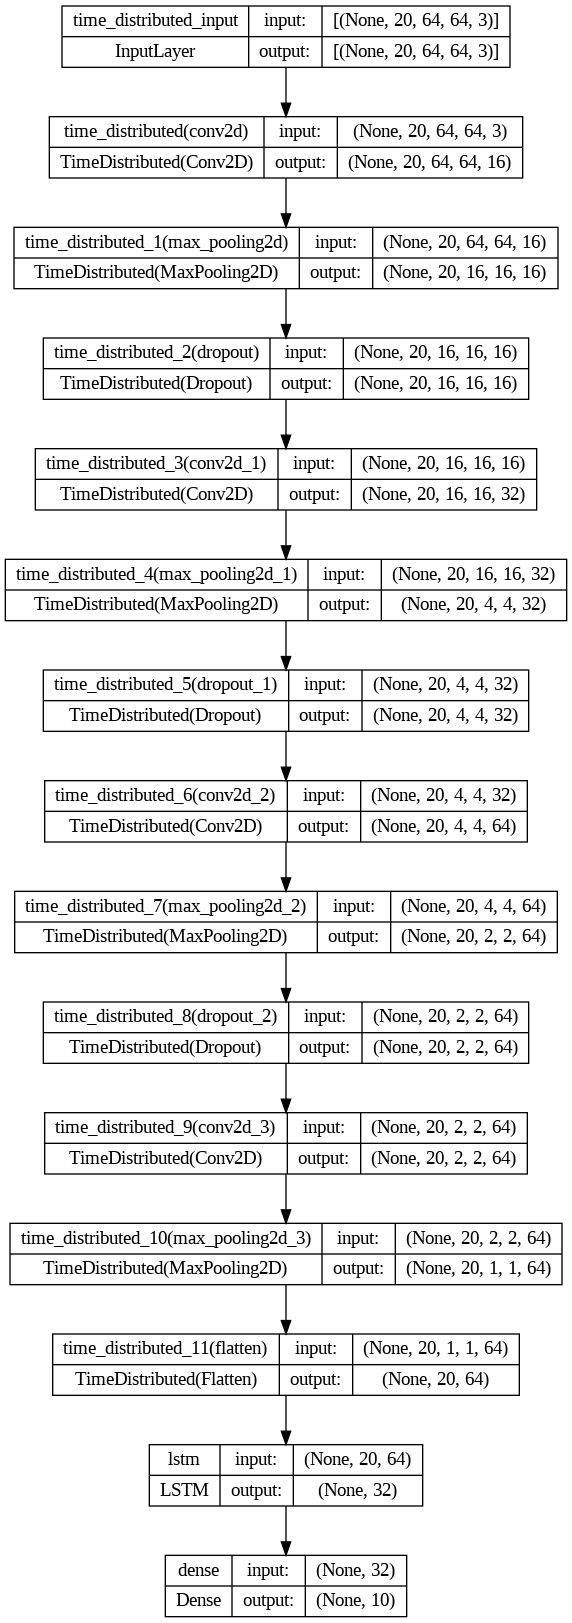

In [ ]:
plot_model(LRCN_model,to_file = 'LRCN_model_Structure_plot.png',show_shapes=True,show_layer_names = True)

In [16]:
def plot_metric(model_training_history,metric_name1,metric_name2,plot_name):
  metric_value1 = model_training_history.history[metric_name1]
  metric_value2 = model_training_history.history[metric_name2]

  epochs = range(len(metric_value1))

  plt.plot(epochs,metric_value1,'blue',label=metric_name1)
  plt.plot(epochs,metric_value2,'red',label=metric_name2)
  plt.title(str(plot_name))

  plt.legend()

# MODEL TRAINING

1. Learning Rate: The choice of the learning rate (lr),a value of 0.001 (default value for Adam optimizer)  model to converge effectively without causing divergence.

2. Optimizer: The Adam optimizer was chosen because it combines the benefits of both AdaGrad and RMSProp, providing effective optimization for training.

3. Epochs: The number of epochs (100) was selected based on early stopping to prevent overfitting while allowing the model to train until convergence.

4. Batch Size: A batch size of 4 was chosen to have a balance between computation efficiency and model stability during training.

5. Loss Function: Categorical Crossentropy was chosen as the loss function because it is suitable for multi-class classification tasks and helps the model to minimize the difference between predicted and actual class probabilities.

In [13]:
import time

# before training
start_time = time.time()

early_stopping_callback = EarlyStopping(monitor='accuracy', patience=10, mode='max', restore_best_weights=True)

LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training
LRCN_model_training_history = LRCN_model.fit(x=features_train, y=labels_train, epochs=100, batch_size=4,
                                             shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

# end time after training
end_time = time.time()

# total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")


Epoch 1/100
210/210 [==============================] - 64s 285ms/step - loss: 2.2857 - accuracy: 0.1637 - val_loss: 2.2180 - val_accuracy: 0.1429
Epoch 2/100
210/210 [==============================] - 46s 218ms/step - loss: 1.9896 - accuracy: 0.2867 - val_loss: 1.7623 - val_accuracy: 0.2905
Epoch 3/100
210/210 [==============================] - 48s 227ms/step - loss: 1.6800 - accuracy: 0.4146 - val_loss: 1.6667 - val_accuracy: 0.4429
Epoch 4/100
210/210 [==============================] - 49s 233ms/step - loss: 1.4914 - accuracy: 0.4934 - val_loss: 1.3236 - val_accuracy: 0.5667
Epoch 5/100
210/210 [==============================] - 46s 220ms/step - loss: 1.4182 - accuracy: 0.5030 - val_loss: 1.2893 - val_accuracy: 0.5810
Epoch 6/100
210/210 [==============================] - 46s 219ms/step - loss: 1.2485 - accuracy: 0.5687 - val_loss: 1.2132 - val_accuracy: 0.6000
Epoch 7/100
210/210 [==============================] - 45s 216ms/step - loss: 1.1579 - accuracy: 0.6081 - val_loss: 1.0671 -

In [14]:
model_evaluation_history = LRCN_model.evaluate(features_test,lables_test)

11/11 [==============================] - 6s 523ms/step - loss: 0.5794 - accuracy: 0.8800


# SAVING MODEL

In [ ]:
model_evaluation_loss,model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m%_%d_%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name = f'LRCN_model_Date_Time_{current_date_time_string}_Loss{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# LOAD TRAINED MODEL

In [17]:
from keras.models import load_model

# Load the LRCN model from a local file
model_path = '/content/drive/MyDrive/Cognitica/LRCN_model_Date_Time_2023_09%d_09_38_43_Loss0.4353593587875366_Accuracy_0.9142857193946838.h5'
LRCN_model = load_model(model_path)


In [ ]:
model_file_name

'LRCN_model_Date_Time_2023_09%d_08_47_14_Loss0.5378007292747498_Accuracy_0.8828571438789368.h5'

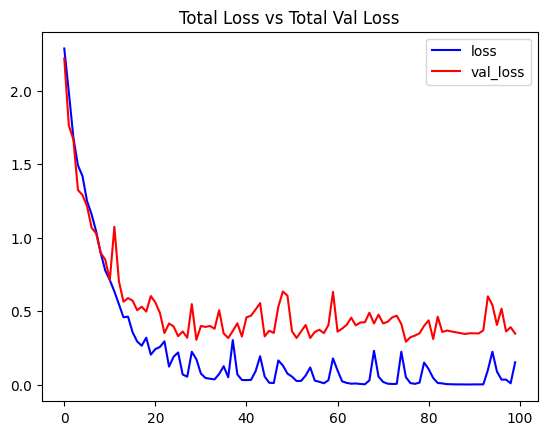

In [18]:
plot_metric(LRCN_model_training_history,'loss','val_loss','Total Loss vs Total Val Loss')

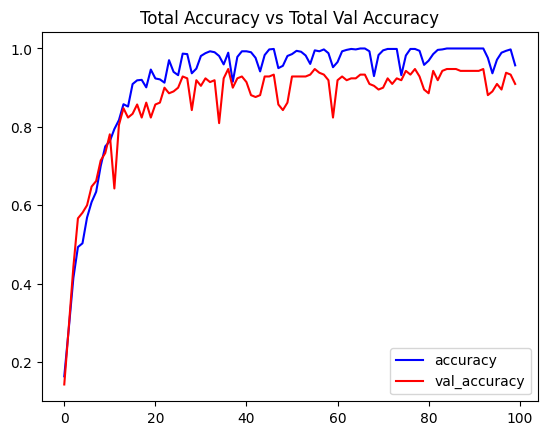

In [19]:
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Total Val Accuracy')

# TESTING

In [12]:
!pip install moviepy

In [14]:
import os
from moviepy.editor import VideoFileClip
test_videos_directory='test_videos'
os.makedirs(test_videos_directory,exist_ok=True)


input_video_file_path = '/content/drive/MyDrive/Cognitica/Test_dir/v_Diving_g25_c02.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]

print(f"Video Name: {video_title}")


Video Name: v_Diving_g25_c02


In [61]:

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                  video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break  # Exit the loop when there are no more frames

        # Check if the frame is empty before resizing
        if not frame.size:
            continue

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            video_writer.write(frame)

    video_reader.release()
    video_writer.release()


In [16]:
%%capture


output_dir = "/content/drive/MyDrive/Cognitica/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)


processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))
processed_video.ipython_display()


  warnings.warn("Warning: in file %s, "%(self.filename)+



In [17]:
processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [20]:
%%capture
input_video_file_path = '/content/drive/MyDrive/Cognitica/Test_dir/v_HighJump_g25_c04.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]

print(f"Video Name: {video_title}")

output_dir="/content/drive/MyDrive/Cognitica/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))

In [21]:

processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [26]:
%%capture
input_video_file_path = '/content/drive/MyDrive/Cognitica/Test_dir/v_Drumming_g25_c07.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]


print(f"Video Name: {video_title}")
output_dir="/content/drive/MyDrive/Cognitica/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))

In [27]:

processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [28]:
%%capture
input_video_file_path = '/content/drive/MyDrive/Cognitica/Test_dir/v_HorseRace_g25_c04.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]


print(f"Video Name: {video_title}")
output_dir="/content/drive/MyDrive/Cognitica/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))

In [29]:


processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  97%|█████████▋| 245/253 [00:00<00:00, 279.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Cognitica/Output/v_HorseRace_g25_c04-Output-SeqLen20.mp4, 360000 bytes wanted but 0 bytes read,at frame 252/253, at time 8.41/8.41 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [30]:
%%capture
input_video_file_path = '/content/drive/MyDrive/Cognitica/Test_dir/v_PushUps_g26_c04.avi'


video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]


print(f"Video Name: {video_title}")
output_dir="/content/drive/MyDrive/Cognitica/Output"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))

In [31]:

processed_video.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**MODEL EVALUATION**

In [73]:
%%capture

true_labels = []  # true labels for each frame
predicted_labels = []  # predicted labels for each frame
#predict labels for a video
def predict_on_video(video_file_path, true_label):
    video_reader = cv2.VideoCapture(video_file_path)
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break


        if not frame.size:
            continue

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]


            true_labels.append(true_label)
            predicted_labels.append(predicted_class_name)

    video_reader.release()

    return true_labels, predicted_labels

#test vids
class_name_mapping = {
    'v_Diving_g25_c02': 'Diving',
    'v_Drumming_g25_c07': 'Drumming',
    'v_HighJump_g25_c04': 'HighJump',
    'v_HorseRace_g25_c04': 'HorseRace',
    'v_HorseRiding_g25_c21': 'HorseRiding',
    'v_JumpingJack_g25_c07': 'JumpingJack',
    'v_PlayingTabla_g22_c04': 'PlayingTabla',
    'v_PoleVault_g17_c09': 'PoleVault',
    'v_PommelHorse_g05_c04': 'PommelHorse',
    'v_PushUps_g26_c04': 'PushUps',
}

all_true_labels = []
all_predicted_labels = []


test_videos_directory = '/content/drive/MyDrive/Cognitica/Test_dir'

for video_file in os.listdir(test_videos_directory):
    if video_file.endswith(".avi"):
        video_file_path = os.path.join(test_videos_directory, video_file)
        video_title = os.path.splitext(os.path.basename(video_file_path))[0]

        # Map video_title
        class_name = class_name_mapping.get(video_title, 'Unknown')


        true_labels_video, predicted_labels_video = predict_on_video(video_file_path, true_label=class_name)

        all_true_labels.extend(true_labels_video)
        all_predicted_labels.extend(predicted_labels_video)



**CLASSIFICATION REPORT**

In [75]:

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

    report = classification_report(all_true_labels, all_predicted_labels)

    print(report)



              precision    recall  f1-score   support

      Diving       0.86      1.00      0.92       516
    Drumming       1.00      1.00      1.00      1405
    HighJump       1.00      0.39      0.56       231
   HorseRace       1.00      1.00      1.00       504
 HorseRiding       0.99      1.00      0.99      2210
 JumpingJack       1.00      1.00      1.00       483
PlayingTabla       1.00      1.00      1.00      2943
   PoleVault       0.97      0.98      0.98      1520
 PommelHorse       0.96      1.00      0.98       275
     PushUps       1.00      1.00      1.00       216

    accuracy                           0.98     10303
   macro avg       0.98      0.94      0.94     10303
weighted avg       0.99      0.98      0.98     10303



**CONFUSION MATRIX**

In [76]:

confusion = confusion_matrix(all_true_labels, all_predicted_labels)

print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[ 516    0    0    0    0    0    0    0    0    0]
 [   0 1405    0    0    0    0    0    0    0    0]
 [  84    0   90    0    0    0    0   45   12    0]
 [   0    0    0  504    0    0    0    0    0    0]
 [   0    0    0    0 2210    0    0    0    0    0]
 [   0    0    0    0    0  483    0    0    0    0]
 [   0    0    0    0    0    0 2943    0    0    0]
 [   0    0    0    0   24    0    0 1496    0    0]
 [   0    0    0    0    0    0    0    0  275    0]
 [   0    0    0    0    0    0    0    0    0  216]]
